In [431]:
import numpy as np
from quimb.utils import progbar as Progbar
from mpi4py import MPI
import pickle
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# torch
from torch.nn.parameter import Parameter
import torch
import torch.nn as nn

# quimb
import quimb as qu
import quimb.tensor as qtn
import symmray as sr
import autoray as ar
from autoray import do

from experiment.tn_model import fTNModel, fTN_NNiso_Model, fTN_NN_Model, fTN_Transformer_Model, SlaterDeterminant, NeuralBackflow
from vmc_torch.sampler import MetropolisExchangeSampler
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import TrivialPreconditioner, SignedSGD, SGD, SR
from vmc_torch.VMC import VMC
from vmc_torch.hamiltonian import square_lattice_spinless_Fermi_Hubbard
from vmc_torch.fermion_utils import generate_random_fpeps

from vmc_torch.global_var import DEBUG


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

L = 4
Lx = int(L)
Ly = int(L)
symmetry = 'U1'
t = 1.0
V = 1.0
N_f = int(Lx*Ly/2)-2
# TN parameters
D = 4
chi = 4

H, hi, graph = square_lattice_spinless_Fermi_Hubbard(Lx, Ly, t, V, N_f)

# skeleton = pickle.load(open(f"../data/{Lx}x{Ly}/t={t}_V={V}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl", "rb"))
# peps_params = pickle.load(open(f"../data/{Lx}x{Ly}/t={t}_V={V}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl", "rb"))
# peps = qtn.unpack(peps_params, skeleton)
# peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32, requires_grad=True))

N_samples = 32
N_samples = N_samples - N_samples % SIZE + SIZE

# model = fTNModel(peps, max_bond=chi)
# model = fTN_NNiso_Model(peps, max_bond=chi, nn_hidden_dim=32, nn_eta=1e-3)
# model = fTN_NN_Model(peps, max_bond=chi, nn_hidden_dim=32, nn_eta=1e-3)
# model = fTN_Transformer_Model(
#     peps, 
#     max_bond=chi, 
#     nn_eta=1e-4, 
#     d_model=8, 
#     nhead=2, 
#     num_encoder_layers=2, 
#     num_decoder_layers=2,
#     dim_feedforward=32,
#     dropout=0.1,
# )
# model = SlaterDeterminant(hi)
model = NeuralBackflow(hi)
init_step = 0
total_steps = 50

if init_step != 0:
    saved_model_params = torch.load(f'../data/{Lx}x{Ly}/t={t}_V={V}/N={N_f}/{symmetry}/D={D}/fTN/chi={chi}/model_params_step{init_step}.pth')
    saved_model_state_dict = saved_model_params['model_state_dict']
    saved_model_params_vec = torch.tensor(saved_model_params['model_params_vec'])
    try:
        model.load_state_dict(saved_model_state_dict)
    except:
        model.load_params(saved_model_params_vec)

# except:
#     print('Use SU TNS parameters as initial parameters')

optimizer = SignedSGD(learning_rate=0.05)
# optimizer = SGD(learning_rate=1e-3)

sampler = MetropolisExchangeSampler(hi, graph, N_samples=N_samples, burn_in_steps=5)
# sampler = None

variational_state = Variational_State(model, hi=H.hilbert, sampler=sampler)

preconditioner = SR(dense=False, exact=True if sampler is None else False, use_MPI4Solver=True, diag_eta=0.05)
# preconditioner = TrivialPreconditioner()

vmc = VMC(H, variational_state, optimizer, preconditioner)
# vmc.run(init_step, init_step+total_steps, tmpdir=f'./')
torch.autograd.set_detect_anomaly(False) # Setting this to True will significantly slow down the code
torch.set_printoptions(precision=10, threshold=float('inf'))

0
1
2
3
4
5
6
7
8
9


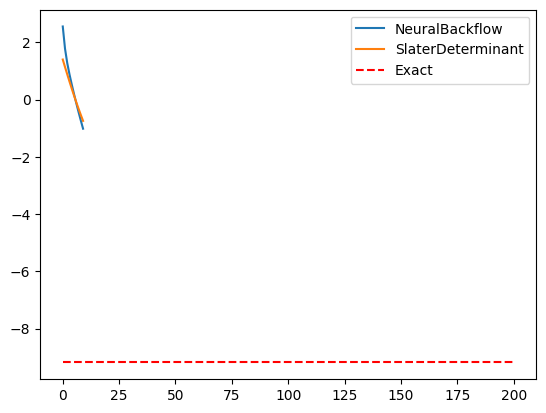

In [434]:
random_conf = np.zeros(Lx*Ly)
random_conf[:N_f] = 1
# np.random.seed(1)
np.random.shuffle(random_conf)
all_config = np.asarray(hi.all_states())
model = NeuralBackflow(hi, hidden_dim=2)
model1 = SlaterDeterminant(hi)
H_dense = torch.tensor(H.to_dense(), dtype=torch.float32)
E_list = []
E1_list = []
for _ in range(10):
    print(_)
    psi = model(all_config)
    psi = psi / torch.norm(psi)
    psi1 = model1(all_config)
    psi1 = psi1 / torch.norm(psi1)
    
    E = torch.dot(psi, H_dense @ psi)
    E1 = torch.dot(psi1, H_dense @ psi1)

    E.backward()
    E1.backward()
    model_vec_param = model.from_params_to_vec()
    model1_vec_param = model1.from_params_to_vec()
    model_vec_param_grad = model.params_grad_to_vec()
    model1_vec_param_grad = model1.params_grad_to_vec()

    new_model_vec_param = model_vec_param - 0.05 * model_vec_param_grad
    new_model1_vec_param = model1_vec_param - 0.05 * model1_vec_param_grad

    model.load_params(new_model_vec_param)
    model1.load_params(new_model1_vec_param)

    model.zero_grad()
    model1.zero_grad()

    E_list.append(E.item())
    E1_list.append(E1.item())

import matplotlib.pyplot as plt
plt.plot(E_list, label='NeuralBackflow')
plt.plot(E1_list, label='SlaterDeterminant')
plt.hlines(-9.18527254892108, 0, 20, colors='r', linestyles='dashed', label='Exact')
plt.legend()
plt.show()


In [67]:
print(model.params_grad_to_vec())

tensor([ 0.0000000000,  0.0000000000, -0.5185189247, -0.8069363236,
         1.6179469824,  2.1435327530,  0.0000000000,  0.0000000000,
         0.0000000000,  0.7542719841,  0.7542719841,  0.0000000000,
         0.0000000000,  0.8516092300,  0.8516092300,  0.0000000000,
         0.7542719841,  0.8516092300,  0.0000000000, -0.0000000000,
         0.0000000000, -0.0000000000, -0.3476125300,  0.2597894967,
        -0.5409661531,  0.4042930305,  1.0846637487, -0.8106274009,
         1.4370137453, -1.0739575624,  0.0000000000, -0.0000000000,
         0.0000000000, -0.0000000000,  0.0000000000,  0.0000000000,
        -0.5185189247, -0.8069363236,  1.6179469824,  2.1435327530,
         0.0000000000,  0.0000000000])


In [7]:
from vmc_torch.torch_utils import SVD,QR

# Register safe SVD and QR functions to torch
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)

random_conf = np.zeros(Lx*Ly)
random_conf[:N_f] = 1
# np.random.seed(1)
np.random.shuffle(random_conf)
amp = peps.get_amp(random_conf, conj=True)
print(amp.contract())
# amp = amp.contract_boundary_from_ymin(max_bond=chi, cutoff=0.0, yrange=(0, amp.Ly-2))
# model.amplitude([random_conf])
model = fTNModel(peps)
amp.contract(), model(torch.tensor([random_conf]))

tensor(-1.0946e-07, grad_fn=<ViewBackward0>)


(tensor(-1.0946e-07, grad_fn=<ViewBackward0>),
 tensor([-1.0946e-07], grad_fn=<StackBackward0>))

In [97]:
# Hamiltonian parameters
Lx = int(4)
Ly = int(4)
symmetry = 'U1'
t = 1.0
V = 1.0
N_f = int(Lx*Ly/2)-2
H, hi, graph = square_lattice_spinless_Fermi_Hubbard(Lx, Ly, t, V, N_f)

# Exact diagonalization of the Hamiltonian for benchmark
sp_h = H.to_sparse() # Convert the Hamiltonian to a sparse matrix
from scipy.sparse.linalg import eigsh
eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
E_gs = eig_vals[0]
print("Exact ground state energy per site:", E_gs)

Exact ground state energy per site: -9.185272548921091


In [86]:
from vmc_torch.torch_utils import SVD,QR
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)
current_config = sampler.current_config
with torch.autograd.set_detect_anomaly(True):
    variational_state.amplitude_grad(current_config)

In [56]:
random_conf = np.zeros(Lx*Ly)
random_conf[:N_f] = 1
# np.random.seed(1)
np.random.shuffle(random_conf)
amp = peps.get_amp(random_conf)
amp.contract_boundary_from_ymin_(max_bond=chi, cutoff=0.0, yrange=(0, amp.Ly-2))
amp.contract()

tensor(-7.1975e-08, grad_fn=<NegBackward0>)

In [12]:
random_conf = np.zeros(Lx*Ly)
random_conf[:N_f] = 1
# np.random.seed(1)
np.random.shuffle(random_conf)
model = fTN_Transformer_Model(
    peps, 
    max_bond=chi, 
    nn_eta=1e-3, 
    d_model=8, 
    nhead=2, 
    num_encoder_layers=2, 
    num_decoder_layers=2,
    dim_feedforward=32,
    dropout=0.1,
)
import pyinstrument
# with pyinstrument.profile():
result = model.amplitude([torch.tensor(random_conf, dtype=torch.float32)])
sum(result).backward()
model.num_params, model.num_tn_params

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/sijingdu/TNVMC/VMC_code/vmc_torch/experiment/tn_model.py:636: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_i = torch.tensor(x_i, dtype=torch.int32)


(5865, 1600)

In [18]:
random_conf = np.zeros(Lx*Ly)
random_conf[:N_f] = 1
np.random.seed(1)
np.random.shuffle(random_conf)
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32, requires_grad=True))
amp = peps.get_amp(random_conf, conj=True)
import pyinstrument
with pyinstrument.profile():
    amp.contract()

/tmp/ipykernel_30436/3065565049.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32, requires_grad=True))

pyinstrument ........................................
.
.  Block at /tmp/ipykernel_30436/3065565049.py:8
.
.  0.057 <module>  ../../../../../tmp/ipykernel_30436/3065565049.py:8
.  └─ 0.057 PEPS.contract  quimb/tensor/tensor_core.py:8396
.        [5 frames hidden]  functools, quimb, cotengra
.           0.057 wrapper  functools.py:883
.           └─ 0.057 tensordot_fermionic  symmray/fermionic_core.py:711
.              ├─ 0.041 tensordot_abelian  symmray/abelian_core.py:1996
.              │  └─ 0.041 _tensordot_via_fused  symmray/abelian_core.py:1941
.              │     ├─ 0.018 Z2FermionicArray.fuse  symmray/abelian_core.py:1418
.              │     │  ├─ 0.007 <

In [6]:
import jax
import random
from vmc_torch.fermion_utils import insert_proj_peps
from quimb.tensor.tensor_core import bonds, tags_to_oset, rand_uuid
from quimb.tensor.tensor_2d import Rotator2D, pairwise
rand_int = random.randint(0, 2**32-1)
hi.random_state(jax.random.PRNGKey(rand_int))
rand_int = random.randint(0, 2**32-1)
random_input = hi.random_state(jax.random.PRNGKey(rand_int))

In [19]:
def insert_compressor(tn, ltags, rtags, new_ltags=None, new_rtags=None, max_bond=4, inplace=False, draw_tn=False):
    """Insert a compressor between two sets of tags."""
    amp_x = tn.copy() if not inplace else tn
    tn_backup = tn.copy()

    amp2, lrtn = amp_x.partition(ltags+rtags, inplace=False)
    rtn, ltn = lrtn.partition(ltags, inplace=False)

    lts = ltn.contract()
    rts = rtn.contract()

    bix = bonds(lts, rts)
    left_inds = tags_to_oset(lts.inds) - bix
    right_inds = tags_to_oset(rts.inds) - bix

    # # test
    # ixmap = {ix: rand_uuid() for ix in bix}
    # tnd = ltn.reindex(ixmap).conj_() & ltn
    # lXX = tnd.to_dense(ixmap.values(), ixmap.keys())
    # # s2, W = do('linalg.eigh', lXX)
    # print(lXX.to_dense())

    Ql,Rl = lts.split(left_inds=left_inds, get='tensors', method='qr')
    Rr,Qr = rts.split(left_inds=bix, get='tensors', method='lq')

    M = (Rl&Rr).contract()
    M.drop_tags()

    U, s, Vd = M.split(
        left_inds=Ql.bonds(M),
        get='tensors',
        absorb=None,
        method='svd',
        max_bond=max_bond,
        cutoff=0.0,
    )

    U_array = U.data
    Vd_array = Vd.data
    # absorb the singular values block by block (only works for blocked matrices)
    for c0, c1 in U_array.sectors:
        s_sqrt_inv = 1 / ar.do('sqrt', s.data.blocks[c1])
        # Torch back propagation does not allow in-place operation like x*=y, must use out-of-place operation x=x*y for future gradient computation.
        U_array.blocks[(c0,c1)] = U_array.blocks[(c0,c1)] * s_sqrt_inv.reshape((1, -1)) 
        Vd_array.blocks[(c0,c1)] = Vd_array.blocks[(c0,c1)] * s_sqrt_inv.reshape((-1, 1))

    U.modify(data=U_array.conj())
    Vd.modify(data=Vd_array.conj())


    Pl = (Rr|Vd).contract()
    Pr = (U|Rl).contract()
    
    new_bix_left = tags_to_oset([rand_uuid(),rand_uuid()])
    new_bix_right = tags_to_oset([rand_uuid(),rand_uuid()])
    Pl.reindex_(dict(zip(bix, new_bix_left)))
    Pr.reindex_(dict(zip(bix, new_bix_right)))
    Pl.drop_tags()
    Pr.drop_tags()
    new_ltags = tags_to_oset(new_ltags) | tags_to_oset('proj')# | tags_to_oset(ltags)
    new_rtags = tags_to_oset(new_rtags) | tags_to_oset('proj')# | tags_to_oset(rtags)
    Pl.add_tag(new_ltags)
    Pr.add_tag(new_rtags)

    ltn.reindex_(dict(zip(bix, new_bix_left)))
    rtn.reindex_(dict(zip(bix, new_bix_right)))
    tn0 = (amp2|ltn|Pr|Pl|rtn)
    
    if draw_tn:
        tn0.draw(color=['proj'], figsize=(12, 12))

    return tn0

def insert_proj_peps(amp, max_bond, yrange, xrange=None, from_which='ymin', lazy=True):
    """Insert projectors in a PEPS along the x direction towards y direction."""
    if yrange is None:
        yrange = [0, amp.Ly-1]
    r = Rotator2D(amp, xrange=xrange, yrange=yrange, from_which=from_which)
    tn_calc = amp.copy()
    for i, inext in pairwise(r.sweep):
        i_passed = [x for x in range(i)]
        # we compute the projectors from an untouched copy
        tn_calc = tn_calc.copy()
        for j in r.sweep_other:
            # this handles cyclic boundary conditions
            jnext = r.get_jnext(j)
            if jnext is not None:
                ltags = (r.site_tag(i, j), r.site_tag(inext, j))
                rtags = (r.site_tag(i, jnext), r.site_tag(inext, jnext))
                # new_ltags = (r.site_tag(inext, j),)
                # new_rtags = (r.site_tag(inext, jnext),)
                #      │         │
                #    ──O─┐ chi ┌─O──  j+1
                #      │ └─▷═◁─┘│
                #      │ ┌┘   └┐ │
                #    ──O─┘     └─O──  j
                #     i+1        i
                tn_calc = insert_compressor(
                    tn_calc,
                    ltags,
                    rtags,
                    new_ltags=ltags,
                    new_rtags=rtags,
                    max_bond=max_bond,
                )
            if not lazy:
                # contract each pair of boundary tensors with their projectors
                for j in r.sweep_other:
                    tn_calc.contract_tags_(
                        (r.site_tag(i, j), r.site_tag(inext, j)),
                    )

    return tn_calc

random_bpeps = qtn.PEPS.rand(6,6,2,seed=10)
ind_map = {ind: int(s) for (ind, s) in zip(random_bpeps.site_inds, random_input)}
bamp = random_bpeps.isel(ind_map)
max_bond = 16
bamp_w_proj_lazy = bamp.contract_boundary_from_ymin(yrange=(0, bamp.Ly-1), max_bond=max_bond, mode='projector', lazy=True)
bamp_w_proj = bamp.contract_boundary_from_ymin(yrange=(0, bamp.Ly-1), max_bond=max_bond, mode='projector', lazy=False)
print(bamp.contract(), bamp_w_proj_lazy.contract(), bamp_w_proj.contract())
print('relative contraction error:')
print(abs(bamp_w_proj.contract()-bamp.contract())/abs(bamp.contract()), abs(bamp_w_proj_lazy.contract()-bamp.contract())/abs(bamp.contract()))

1.0708414128327335e-07 1.0918459433578622e-07 1.0708410042192721e-07
relative contraction error:
3.8158167629967565e-07 0.019614977786080078


In [20]:
rand_int = random.randint(0, 2**32-1)
hi.random_state(jax.random.PRNGKey(rand_int))
rand_int = random.randint(0, 2**32-1)
random_input = hi.random_state(jax.random.PRNGKey(rand_int))

In [21]:
import pyinstrument
with pyinstrument.profile():
    amp = peps.get_amp(random_input)
    amp.contract_boundary_from_ymin_(cutoff=0.0, max_bond=8, yrange=(0, amp.Ly//2-1))
    amp.contract_boundary_from_ymax_(cutoff=0.0, max_bond=8, yrange=(amp.Ly//2, amp.Ly-1))
    # insert_proj_peps(amp, max_bond=8, yrange=(0, amp.Ly-2), lazy=False).contract()
    amp.contract()


pyinstrument ........................................
.
.  Block at /tmp/ipykernel_30436/2002423914.py:2
.
.  0.124 <module>  ../../../../../tmp/ipykernel_30436/2002423914.py:2
.  ├─ 0.044 PEPS.contract_boundary_from_ymin  quimb/tensor/tensor_2d.py:2003
.  │     [35 frames hidden]  quimb, functools, autoray, cotengra
.  │        0.009 do  autoray/autoray.py:30
.  │        └─ 0.009 fuse  symmray/interface.py:117
.  │           └─ 0.009 Z2FermionicArray.fuse  symmray/fermionic_core.py:556
.  │              └─ 0.007 Z2FermionicArray.fuse  symmray/abelian_core.py:1418
.  │                 └─ 0.003 _VariableFunctionsClass.reshape  <built-in>
.  │        0.007 wrapper  functools.py:883
.  │        └─ 0.007 tensordot_fermionic  symmray/fermionic_core.py:711
.  │           └─ 0.006 tensordot_abelian  symmray/abelian_core.py:1996
.  │              └─ 0.006 _tensordot_via_fused  symmray/abelian_core.py:1941
.  │                 ├─ 0.002 Z2FermionicArray.unfuse  symmray/abelian_core.py:1536
.  │

In [22]:
amp = peps.get_amp(random_input, conj=True)
with pyinstrument.profile():
    amp.contract_boundary_from_ymin(max_bond=8, yrange=(0, amp.Ly-2), cutoff=0.0).contract()


pyinstrument ........................................
.
.  Block at /tmp/ipykernel_30436/1804677802.py:2
.
.  0.092 <module>  ../../../../../tmp/ipykernel_30436/1804677802.py:2
.  ├─ 0.088 PEPS.contract_boundary_from_ymin  quimb/tensor/tensor_2d.py:2003
.  │     [74 frames hidden]  quimb, functools, autoray, <built-in>...
.  │        0.009 Composed.__call__  autoray/autoray.py:921
.  │        └─ 0.009 qr_stabilized  symmray/linalg.py:118
.  │           └─ 0.009 wrapper  functools.py:883
.  │              └─ 0.009 qr_fermionic  symmray/linalg.py:107
.  │                 └─ 0.009 qr  symmray/linalg.py:46
.  │                    └─ 0.009 _qr  symmray/linalg.py:26
.  │                       ├─ 0.008 qr_stabilized  quimb/tensor/decomp.py:669
.  │                       │     [5 frames hidden]  autoray, <built-in>, quimb
.  │                       └─ 0.001 [self]  symmray/linalg.py
.  │        0.005 do  autoray/autoray.py:30
.  │        └─ 0.005 reshape  symmray/interface.py:58
.  │         

In [23]:
with pyinstrument.profile():
    model.amplitude([np.array(random_input)])


pyinstrument ........................................
.
.  Block at /tmp/ipykernel_30436/1323872403.py:1
.
.  0.389 <module>  ../../../../../tmp/ipykernel_30436/1323872403.py:1
.  └─ 0.389 fTN_NNiso_Model.amplitude  experiment/tn_model.py:293
.     ├─ 0.287 insert_proj_peps  vmc_torch/fermion_utils.py:270
.     │  └─ 0.282 insert_compressor  vmc_torch/fermion_utils.py:204
.     │     ├─ 0.166 TensorNetwork.contract  quimb/tensor/tensor_core.py:8396
.     │     │     [8 frames hidden]  functools, quimb, cotengra, autoray
.     │     │        0.149 wrapper  functools.py:883
.     │     │        └─ 0.148 tensordot_fermionic  symmray/fermionic_core.py:711
.     │     │           ├─ 0.106 tensordot_abelian  symmray/abelian_core.py:1996
.     │     │           │  └─ 0.101 _tensordot_via_fused  symmray/abelian_core.py:1941
.     │     │           │     ├─ 0.055 Z2FermionicArray.fuse  symmray/abelian_core.py:1418
.     │     │           │     │  ├─ 0.023 <dictcomp>  symmray/abelian_core.py:15

In [14]:
from vmc_torch.fermion_utils import insert_proj_peps

In [15]:
with pyinstrument.profile():
    amp = peps.get_amp(random_input)
    amp = insert_proj_peps(amp, max_bond=16, yrange=(0, amp.Ly-2))
    # x0 = amp.contract()


pyinstrument ........................................
.
.  Block at /tmp/ipykernel_30436/755839155.py:1
.
.  0.327 <module>  ../../../../../tmp/ipykernel_30436/755839155.py:1
.  ├─ 0.295 insert_proj_peps  vmc_torch/fermion_utils.py:270
.  │  ├─ 0.288 insert_compressor  vmc_torch/fermion_utils.py:204
.  │  │  ├─ 0.173 TensorNetwork.contract  quimb/tensor/tensor_core.py:8396
.  │  │  │     [7 frames hidden]  functools, quimb, cotengra, autoray
.  │  │  │        0.153 wrapper  functools.py:883
.  │  │  │        └─ 0.153 tensordot_fermionic  symmray/fermionic_core.py:711
.  │  │  │           ├─ 0.114 tensordot_abelian  symmray/abelian_core.py:1996
.  │  │  │           │  └─ 0.114 _tensordot_via_fused  symmray/abelian_core.py:1941
.  │  │  │           │     ├─ 0.049 Z2FermionicArray.fuse  symmray/abelian_core.py:1418
.  │  │  │           │     │  ├─ 0.026 <dictcomp>  symmray/abelian_core.py:1524
.  │  │  │           │     │  │  └─ 0.026 _recurse_concat  symmray/abelian_core.py:1484
.  │  │

In [18]:
random_bpeps = qtn.PEPS.rand(Lx, Ly, bond_dim=D, phys_dim=2)
random_bpeps.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32, requires_grad=True))
ind_map = {ind:0 for ind in random_bpeps.site_inds}
amp0 = random_bpeps.isel(ind_map)
amp0.contract_boundary_from_ymin(max_bond=4, yrange=(0, amp0.Ly-2), cutoff=0.0, mode='mps').contract().backward()